In [3]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = { # thresh=0.1
0.2:[0.574137882739,0.117924053771],
0.4:[0.516598893174,0.0517583826384],
0.8:[0.34328828939,0.0357882812154],
1.2:[0.288284913923,0.0232571237128],
1.6:[0.284424366299,0.0325989118031],
2.0:[0.245942817302,0.0164289592739],
}


0.2: [1146.59523005,58.0103563096],
0.4: [203.145227238,41.9419271046],
0.8: [20.3303583012,2.91239880382],
1.2: [9.6235055325,1.47241037323],
1.6: [3.47495133354,0.532584295573],
2.0: [2.62209604451,0.241241957821],


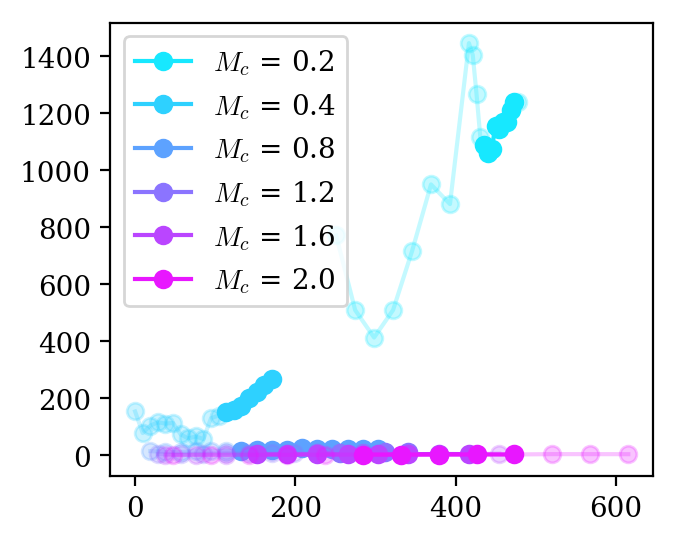

In [16]:
# Scaling using U_delta
s = '1'
# Mc_list = ['08',]#['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


fig = plt.figure(figsize=(3.5,3),dpi=200)
for i,Mc in enumerate(Mc_list):
    if Mc is '04':# or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    directory = dir_out
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        
    flist = glob.glob(directory+"lscale_vv*")
    flist.sort()

    if Mc=='02': ist=12;ien=-1;flist=flist[3:] # mira run
    #if Mc=='02': ist=-7;ien=-4 # theta run
    #elif Mc=='04': ist=8;ien=14 #mira run
    elif Mc=='04': ist=13;ien=None #theta run
    elif Mc=='08': ist=7;ien=None
    elif Mc=='12': ist=8;ien=None
    elif Mc=='16': ist=4;ien=-1
    elif Mc=='20': ist=6;ien=-3
    else: ist=0; ien=None 
        
    colorVal = scalarMap.to_rgba(inp.Mc)
    mat = np.zeros([2,len(flist)])
    for j,fname in enumerate(flist):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]
        eta = y/dtheta
        
        # Get utilde and dudy
        scaling='udelta2'
        if scaling=='du2':
            utilde = np.fromfile(directory+'/shearlayer_utilde_%04d.dat'%tID,sep=' ')
            L99,i1,i2 = get_L99(-y,utilde)
            scale = L99/inp.du**3
        elif scaling=='udelta2':
            # Get lscale y
            autocorr = np.fromfile(directory+'/lscale_vv_%04d.dat'%(tID),sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=0.1)
            scale = ly/(du[inp.Mc][0]*inp.du)**3
            
        fplot = scale 
        #if j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
        #else: plt.plot(-eta,fplot,alpha=0.75,color=colorVal)#label='%s'%fname)#
        #mat[j] = abs(1./dtheta * integrate_y(y,fplot))
        mat[0,j] = time*inp.du
        mat[1,j] = fplot
    isort = np.argsort(mat[0,:])
    mat[0,:] = mat[0,isort]
    mat[1,:] = mat[1,isort]
    plt.plot(mat[0,1:]-mat[0,0],mat[1,1:],'-o',alpha=0.25,color=colorVal)
    plt.plot(mat[0,ist:ien]-mat[0,0],mat[1,ist:ien],'-o',color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
    print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[1,ist:ien]),np.std(mat[1,ist:ien])))
 
plt.legend(fontsize=10)

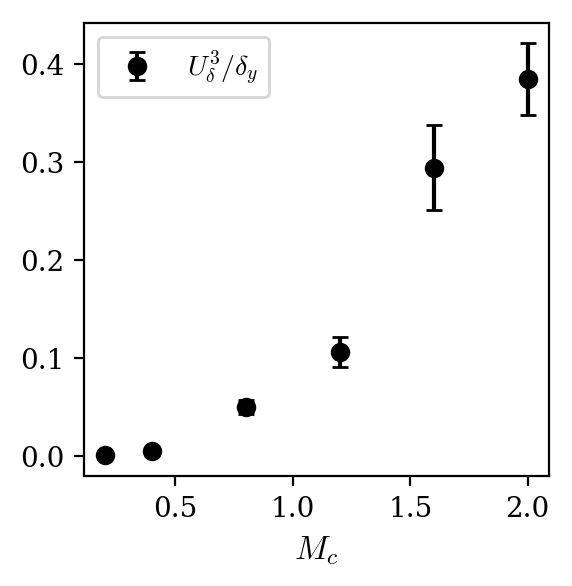

In [23]:
def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

def plotter_v2(ax,dat,fmt,label,colorVal='k'):
    Mcs = []
    vals = []
    errs = []
    for Mc in sorted(dat.keys()):
        Mcs.append( Mc )
        vals.append( dat[Mc][0] )
        errs.append( dat[Mc][1] )
    plt.errorbar(Mcs,vals,color=colorVal,yerr=errs,fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=200)
# plotter(factor['ly_udelta3'],'ko',r'$\delta_y/U_\delta^3$')
plotter(factor['udelta3_ly'],'ko',r'$U_\delta^3/\delta_y$')
plt.xlabel(r'$M_c$')
plt.legend(fontsize=10)#,bbox_to_anchor=(0.5,0.55))
# plt.annotate('(c)',(0.5,0.16),fontsize=10)

In [17]:
factor = {} # sqrt{\bar{p'*p'}}
factor['udelta3_ly'] = {
0.2: [0.000874394782288,4.44672077572e-05],
0.4: [0.00513576222874,0.0010433801497],
0.8: [0.0501663112656,0.00697601677745],
1.2: [0.106225300607,0.0152217403117],
1.6: [0.294337139253,0.0431720578194],
2.0: [0.384724724385,0.0365564110289],
}
factor['ly_udelta3'] = {
0.2: [1146.59523005,58.0103563096],
0.4: [203.145227238,41.9419271046],
0.8: [20.3303583012,2.91239880382],
1.2: [9.6235055325,1.47241037323],
1.6: [3.47495133354,0.532584295573],
2.0: [2.62209604451,0.241241957821],
}